# QLoRA

By Alberto Valdes.

**Mail 1:** anvaldes@uc.cl

**Mail 2:** alberto.valdes.gonzalez.96@gmail.com

This notebook was devoloped in Google Colab using A100 GPU.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import time
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import image as mpimg

In [3]:
def display_img(name, a, b):
    plt.figure(figsize = (a, b))
    image = mpimg.imread(name)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

### Explanation:

* Is LoRA 2.0
* Uses even less memory with "recoverable" quantization.
* Paper of QLoRA has critical findings:
* - Training all layers of the network is necessary to match performance of full-parameter fine-tuning.
* - Rank may not matter from 8 to 256.
* - The most critical LoRA hyperparameter is how many LoRA adapters are used in total (Basically in how many layers we going to impact or changes the weigths).

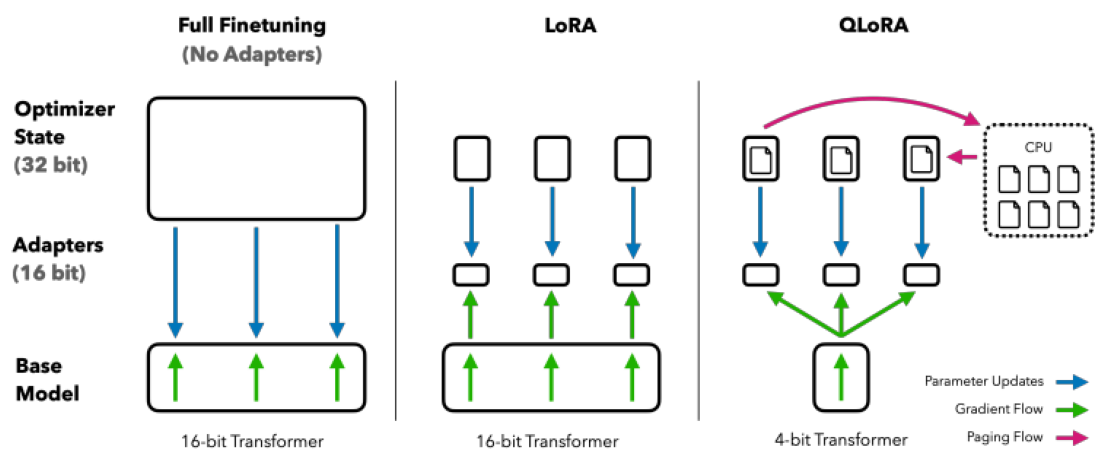

In [4]:
display_img('QLoRA.png', 14, 14)

In [5]:
start = time.time()

# Finetunning

### a. Setting the environment

In [6]:
!pip install torch==2.2.1

  Using cached torch-2.2.1-cp310-cp310-manylinux1_x86_64.whl (755.5 MB)
  Attempting uninstall: torch
    Found existing installation: torch 2.2.2
    Uninstalling torch-2.2.2:
      Successfully uninstalled torch-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xformers 0.0.25.post1 requires torch==2.2.2, but you have torch 2.2.1 which is incompatible.


In [7]:
!pip install -qU bitsandbytes transformers datasets accelerate loralib einops xformers

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.2.1+cu121 requires torch==2.2.1, but you have torch 2.2.2 which is incompatible.
torchtext 0.17.1 requires torch==2.2.1, but you have torch 2.2.2 which is incompatible.
torchvision 0.17.1+cu121 requires torch==2.2.1, but you have torch 2.2.2 which is incompatible.


In [8]:
!pip install -q -U git+https://github.com/huggingface/peft.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


### b. Import Libraries

In [9]:
import os
import bitsandbytes as bnb
import pandas as pd
import torch
import torch.nn as nn
import transformers
from datasets import load_dataset
from peft import (
    LoraConfig,
    PeftConfig,
    get_peft_model,
    prepare_model_for_kbit_training,
)
from transformers import (
    AutoConfig,
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
)

### c. Load the model

In [10]:
model_id = "tiiuae/falcon-7b-instruct"

In [11]:
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [12]:
tokenizer.pad_token = tokenizer.eos_token

In [13]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit = True,
    load_4bit_use_double_quant = True,
    bnb_4bit_quant_type = "nf4",
    bnb_4bit_compute_dtype = torch.bfloat16,
)

Unused kwargs: ['load_4bit_use_double_quant']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.


In [14]:
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype = torch.bfloat16,
    trust_remote_code = True,
    load_in_8bit = True,
    device_map = "auto",
)


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

### d. Import Dataset

In [15]:
from datasets import load_dataset

In [16]:
def generate_prompt(data_point):

  return f"""<Human>: {data_point["Context"]} <AI>: {data_point["Response"]}""".strip()

In [17]:
def generate_and_tokenize_prompt(data_point):

  full_prompt = generate_prompt(data_point)

  tokenized_full_prompt = tokenizer(full_prompt, padding = True, truncation = True)

  return tokenized_full_prompt

In [18]:
dataset_name = 'Amod/mental_health_counseling_conversations'

In [19]:
dataset_train = load_dataset(dataset_name, split = "train[:500]")
dataset_train = dataset_train.shuffle().map(generate_and_tokenize_prompt)

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [20]:
len(dataset_train)

500

In [21]:
dataset_val = load_dataset(dataset_name, split = "train[2500:2600]")
dataset_val = dataset_val.shuffle().map(generate_and_tokenize_prompt)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [22]:
len(dataset_val)

100

In [23]:
dataset_test = load_dataset(dataset_name, split = "train[3000:3100]")
dataset_test = dataset_test.shuffle().map(generate_and_tokenize_prompt)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [24]:
len(dataset_test)

100

**See Dataset: Train**

In [25]:
dataset_train[0]['Context']

"I have these dreams of men, and they always seem to try to hurt me. It's gotten so bad that I first wake at 4:30, then 4:45, and finally stay awake by 6:00. I'm always the last one to fall asleep and the first to wake. I hate falling asleep. The longest I've went without sleep is three days."

In [26]:
dataset_train[0]['Response']

"That is awful! I am sure you are ready to start getting some rest. It's normal for us to wake a few times in the night, however, when we are dealing with high anxiety or stress, those times can turn into being up most night. Given that you are having these repeated dreams, I am wondering what might be going on in your life either now\xa0 or in the past that could be triggering stress or maybe memories. It can help to draw the dream out in the morning or even to look for metaphor. In the long run, seeking counseling can help you sort all that outIn the meantime, self-soothing strategies may help you in the night when you wake and can't get back to sleep. This can be anything with your senses----getting a snack like tea and focusing on that taste, smelling something pleasant, listening to some relaxing music, looking through a magazine, taking a shower. Anything you can think of that might help you relax. If it involves needing to get up, that's okay! Getting out of bed can actually hel

**See Dataset: Val**

In [27]:
dataset_val[0]['Context']

"I'm almost never happy. Half of the time, I don't feel anything. I find it easy to make myself feel nothing. I know I push people away because it’s easier. I just want answers. I'm sick of feeling this way. It’s ruining my relationships with people."

In [28]:
dataset_val[0]['Response']

'Maybe you have depression.The name of your condition matters much less than the descriptions you wrote of how you feel.Since you\'ve observed how you sometimes interact with people and realize you aren\'t happy with the result, you\'ve a very solid starting point for reflecting on your deeper wishes in relating to others.Start with asking reasons of yourself about the puzzling aspects of how you\'re engaging with others.Theorizing as to "why" you feel that pushing people away is "easier", and easier than what?Googling the keywords of how you feel, may open a starting point for ideas on knowing yourself and what you wish for.'

**See Dataset: Test**

In [29]:
dataset_test[0]['Context']

"How do therapists classify the type of personality their clients have?  What characteristics do they look at to decide what type of personality the client has? I've read about this online, but I'd like to understand this from a therapist's point of view."

In [30]:
dataset_test[0]['Response']

'That\'s a great question. There is such a wide range of ways to define "personality" that it is difficult to identify specific characteristics that are used to identify personality types.That being said, some clinicians will use standardized tests (or assessments) to assess a client\'s type of personality. While these tests can\'t tell us everything about a person, they can help us understand where we are within larger groups of different personality styles.Some counselors will also use a diagnostic tool (like the DSM or ICD) to help a client understand a diagnosis that is related to a personality disorder.'

### e. Inference

In [31]:
def inference_model(model, tokenizer, text):

  pipeline = transformers.pipeline(
      "text-generation",
      model = model,
      tokenizer = tokenizer
      )

  sequences = pipeline(
      text,
      max_length = 200,
      do_sample = True,
      top_k = 10,
      num_return_sequences = 1,
      eos_token_id=tokenizer.eos_token_id,
      truncation = True,
      use_cache = False
      )

  all_txt = ""

  for seq in sequences:

    all_txt = all_txt + seq['generated_text']

  return all_txt

**Train**

In [32]:
inf_train = inference_model(model, tokenizer, dataset_train[0]['Context'])

a. Context

In [33]:
print(dataset_train[0]['Context'])

I have these dreams of men, and they always seem to try to hurt me. It's gotten so bad that I first wake at 4:30, then 4:45, and finally stay awake by 6:00. I'm always the last one to fall asleep and the first to wake. I hate falling asleep. The longest I've went without sleep is three days.


b. Answer

In [34]:
print(dataset_train[0]['Response'])

That is awful! I am sure you are ready to start getting some rest. It's normal for us to wake a few times in the night, however, when we are dealing with high anxiety or stress, those times can turn into being up most night. Given that you are having these repeated dreams, I am wondering what might be going on in your life either now  or in the past that could be triggering stress or maybe memories. It can help to draw the dream out in the morning or even to look for metaphor. In the long run, seeking counseling can help you sort all that outIn the meantime, self-soothing strategies may help you in the night when you wake and can't get back to sleep. This can be anything with your senses----getting a snack like tea and focusing on that taste, smelling something pleasant, listening to some relaxing music, looking through a magazine, taking a shower. Anything you can think of that might help you relax. If it involves needing to get up, that's okay! Getting out of bed can actually help yo

In [35]:
print(inf_train)

I have these dreams of men, and they always seem to try to hurt me. It's gotten so bad that I first wake at 4:30, then 4:45, and finally stay awake by 6:00. I'm always the last one to fall asleep and the first to wake. I hate falling asleep. The longest I've went without sleep is three days. I'm not joking. I'm not exaggerating.
I have been struggling with insomnia. I am now in the sixth grade. It is a problem with me not being able to fall asleep and stay asleep, especially in the school night.
I am a middle schooler and this is not the time for me to be having nightmares. I have had many nights where I am unable to sleep because of the nightmares. It's like being awake and trying to sleep. My mind is too active in thinking that I can sleep. The only way to sleep is to go


**Val**

In [36]:
inf_val = inference_model(model, tokenizer, dataset_val[0]['Context'])

a. Context

In [37]:
print(dataset_val[0]['Context'])

I'm almost never happy. Half of the time, I don't feel anything. I find it easy to make myself feel nothing. I know I push people away because it’s easier. I just want answers. I'm sick of feeling this way. It’s ruining my relationships with people.


b. Answer

In [38]:
print(dataset_val[0]['Response'])

Maybe you have depression.The name of your condition matters much less than the descriptions you wrote of how you feel.Since you've observed how you sometimes interact with people and realize you aren't happy with the result, you've a very solid starting point for reflecting on your deeper wishes in relating to others.Start with asking reasons of yourself about the puzzling aspects of how you're engaging with others.Theorizing as to "why" you feel that pushing people away is "easier", and easier than what?Googling the keywords of how you feel, may open a starting point for ideas on knowing yourself and what you wish for.


In [39]:
print(inf_val)

I'm almost never happy. Half of the time, I don't feel anything. I find it easy to make myself feel nothing. I know I push people away because it’s easier. I just want answers. I'm sick of feeling this way. It’s ruining my relationships with people. But I’m also afraid of being happy. What if I'm too happy and something bad happens? I just want happiness without that fear, and I know it’s impossible to do that. I'm just sick of feeling this way.
I don't know if I could be happy without medication or if it would even be possible.
<p>If you're currently seeking help from a medical professional, I recommend discussing this concern with them during your appointments and working on addressing any underlying issues related to your mental health. It's also important to prioritize self-care practices such as meditation, exercise, and therapy in addition to any medications you


**Test**

In [40]:
inf_test = inference_model(model, tokenizer, dataset_test[0]['Context'])

a. Context

In [41]:
print(dataset_test[0]['Context'])

How do therapists classify the type of personality their clients have?  What characteristics do they look at to decide what type of personality the client has? I've read about this online, but I'd like to understand this from a therapist's point of view.


b. Answer

In [42]:
print(dataset_test[0]['Response'])

That's a great question. There is such a wide range of ways to define "personality" that it is difficult to identify specific characteristics that are used to identify personality types.That being said, some clinicians will use standardized tests (or assessments) to assess a client's type of personality. While these tests can't tell us everything about a person, they can help us understand where we are within larger groups of different personality styles.Some counselors will also use a diagnostic tool (like the DSM or ICD) to help a client understand a diagnosis that is related to a personality disorder.


In [43]:
print(inf_test)

How do therapists classify the type of personality their clients have?  What characteristics do they look at to decide what type of personality the client has? I've read about this online, but I'd like to understand this from a therapist's point of view.
Therapists use a variety of techniques and tools to assess their clients. One common technique is to use a personality test, which can be administered in a session or sent for the client to complete. The test can measure a variety of traits and behaviors, such as extroversion-introversion, openness-extroversion, and conscientiousness-spontaneity. In addition to these tests, therapists may also look at their client's communication style and the way they react in different situations. Some therapists may also consider the client's past experiences and how these may have contributed to their current personality. Overall, the goal of the classification is to gain insight into the client's strengths and weaknesses and provide


### f. QLoRA

In [44]:
generation_config = model.generation_config
generation_config.max_new_tokens = 200
generation_config.temperature = 0.7
generation_config.top_p = 0.7
generation_config.num_return_sequences = 1
generation_config.pad_token_id = tokenizer.eos_token_id
generation_config.eos_token_id = tokenizer.eos_token_id

In [45]:
model = prepare_model_for_kbit_training(model)

You are using an old version of the checkpointing format that is deprecated (We will also silently ignore `gradient_checkpointing_kwargs` in case you passed it).Please update to the new format on your modeling file. To use the new format, you need to completely remove the definition of the method `_set_gradient_checkpointing` in your model.


In [46]:
config = LoraConfig(
    r = 16,
    lora_alpha = 32,
    target_modules = ["query_key_value"],
    lora_dropout = 0.05,
    bias = "none",
    task_type = "CAUSAL_LM"
    )

In [47]:
model = get_peft_model(model, config)

In [48]:
OUTPUT_DIR = 'experiments'

In [49]:
num_epochs = 3

In [50]:
training_args = transformers.TrainingArguments(
    auto_find_batch_size = True,
    num_train_epochs = num_epochs,
    learning_rate = 2e-4,
    bf16 = True,
    save_total_limit = 4,
    logging_steps = 10,
    output_dir = OUTPUT_DIR,
    save_strategy = 'epoch',
    do_eval = True,
    logging_strategy = "epoch",
    evaluation_strategy = "epoch"
)

In [51]:
trainer = transformers.Trainer(
    model = model,
    train_dataset = dataset_train,
    eval_dataset = dataset_val,
    args = training_args,
    data_collator = transformers.DataCollatorForLanguageModeling(tokenizer, mlm = False)
    )

In [52]:
model.config.use_cache = False

### g. Train

In [53]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,2.478200,2.495560
2,2.256400,2.481182
3,2.148700,2.473912


TrainOutput(global_step=189, training_loss=2.2944562800977595, metrics={'train_runtime': 915.0597, 'train_samples_per_second': 1.639, 'train_steps_per_second': 0.207, 'total_flos': 3.336805015515648e+16, 'train_loss': 2.2944562800977595, 'epoch': 3.0})

### h. Evaluation

In [54]:
trainer.evaluate(dataset_train)

{'eval_loss': 2.1242246627807617,
 'eval_runtime': 38.8858,
 'eval_samples_per_second': 12.858,
 'eval_steps_per_second': 1.62,
 'epoch': 3.0}

In [55]:
trainer.evaluate(dataset_val)

{'eval_loss': 2.473912000656128,
 'eval_runtime': 9.7102,
 'eval_samples_per_second': 10.298,
 'eval_steps_per_second': 1.339,
 'epoch': 3.0}

In [56]:
trainer.evaluate(dataset_test)

{'eval_loss': 2.3742706775665283,
 'eval_runtime': 8.6827,
 'eval_samples_per_second': 11.517,
 'eval_steps_per_second': 1.497,
 'epoch': 3.0}

### i. Inference

**Train**

In [57]:
inf_train = inference_model(model, tokenizer, dataset_train[0]['Context'])

The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'JambaForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MistralForCausalLM', 'MixtralForCausalLM', 'MptForCausalLM', 'MusicgenForCausalLM', 'MusicgenMelodyFo

a. Context

In [58]:
print(dataset_train[0]['Context'])

I have these dreams of men, and they always seem to try to hurt me. It's gotten so bad that I first wake at 4:30, then 4:45, and finally stay awake by 6:00. I'm always the last one to fall asleep and the first to wake. I hate falling asleep. The longest I've went without sleep is three days.


b. Answer

In [59]:
print(dataset_train[0]['Response'])

That is awful! I am sure you are ready to start getting some rest. It's normal for us to wake a few times in the night, however, when we are dealing with high anxiety or stress, those times can turn into being up most night. Given that you are having these repeated dreams, I am wondering what might be going on in your life either now  or in the past that could be triggering stress or maybe memories. It can help to draw the dream out in the morning or even to look for metaphor. In the long run, seeking counseling can help you sort all that outIn the meantime, self-soothing strategies may help you in the night when you wake and can't get back to sleep. This can be anything with your senses----getting a snack like tea and focusing on that taste, smelling something pleasant, listening to some relaxing music, looking through a magazine, taking a shower. Anything you can think of that might help you relax. If it involves needing to get up, that's okay! Getting out of bed can actually help yo

In [60]:
print(inf_train)

I have these dreams of men, and they always seem to try to hurt me. It's gotten so bad that I first wake at 4:30, then 4:45, and finally stay awake by 6:00. I'm always the last one to fall asleep and the first to wake. I hate falling asleep. The longest I've went without sleep is three days. I don't know what's wrong with me. I'm not depressed. I'm not anxious. I'm not worried about anything. I'm just tired of being awake at night. I'm a 21 year old woman. I'm a student. I'm a student who works full time and takes care of my little sister. I'm a good girl, but I can't sleep. I can't fall asleep. I can't fall asleep. I can't fall asleep. I can't fall asleep. I can't fall asleep. I can't fall asleep. I can't fall asleep. I can't fall asleep. I can't fall asleep. I can't fall asleep. I can't fall asleep. I can't fall asleep. I can't fall asleep. I can't fall asleep. I can't fall asleep. I can't fall


**Val**

In [61]:
inf_val = inference_model(model, tokenizer, dataset_val[0]['Context'])

The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'JambaForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MistralForCausalLM', 'MixtralForCausalLM', 'MptForCausalLM', 'MusicgenForCausalLM', 'MusicgenMelodyFo

a. Context

In [62]:
print(dataset_val[0]['Context'])

I'm almost never happy. Half of the time, I don't feel anything. I find it easy to make myself feel nothing. I know I push people away because it’s easier. I just want answers. I'm sick of feeling this way. It’s ruining my relationships with people.


b. Answer

In [63]:
print(dataset_val[0]['Response'])

Maybe you have depression.The name of your condition matters much less than the descriptions you wrote of how you feel.Since you've observed how you sometimes interact with people and realize you aren't happy with the result, you've a very solid starting point for reflecting on your deeper wishes in relating to others.Start with asking reasons of yourself about the puzzling aspects of how you're engaging with others.Theorizing as to "why" you feel that pushing people away is "easier", and easier than what?Googling the keywords of how you feel, may open a starting point for ideas on knowing yourself and what you wish for.


In [64]:
print(inf_val)

I'm almost never happy. Half of the time, I don't feel anything. I find it easy to make myself feel nothing. I know I push people away because it’s easier. I just want answers. I'm sick of feeling this way. It’s ruining my relationships with people. I’m not sure how to stop it. -Anonymous
It sounds like you may be experiencing symptoms of depression. Depression is a mental health condition that can cause feelings of sadness, hopelessness, and loss of interest in daily activities. It's important to seek help from a mental health professional. They can provide you with tools to manage your emotions and help you develop a more positive outlook. Some common treatments for depression include therapy, medication, and lifestyle changes.


**Test**

In [65]:
inf_test = inference_model(model, tokenizer, dataset_test[0]['Context'])

The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'JambaForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MistralForCausalLM', 'MixtralForCausalLM', 'MptForCausalLM', 'MusicgenForCausalLM', 'MusicgenMelodyFo

a. Context

In [66]:
print(dataset_test[0]['Context'])

How do therapists classify the type of personality their clients have?  What characteristics do they look at to decide what type of personality the client has? I've read about this online, but I'd like to understand this from a therapist's point of view.


b. Answer

In [67]:
print(dataset_test[0]['Response'])

That's a great question. There is such a wide range of ways to define "personality" that it is difficult to identify specific characteristics that are used to identify personality types.That being said, some clinicians will use standardized tests (or assessments) to assess a client's type of personality. While these tests can't tell us everything about a person, they can help us understand where we are within larger groups of different personality styles.Some counselors will also use a diagnostic tool (like the DSM or ICD) to help a client understand a diagnosis that is related to a personality disorder.


In [68]:
print(inf_test)

How do therapists classify the type of personality their clients have?  What characteristics do they look at to decide what type of personality the client has? I've read about this online, but I'd like to understand this from a therapist's point of view.
As an AI language model, I don't have personal experience or emotions, but I can provide you with some information. 

Therapists may classify their clients based on their personality traits and characteristics. Some common traits that therapists may look for include:

- Openness to Experience (OE): This is the tendency to be open to new experiences and ideas. People with OE tend to be curious and enjoy learning new things.

- Conscientiousness (C): This is the tendency to be self-aware and reflective. People with C tend to be aware of their own strengths and weaknesses.

- Extraversion (E): This is the tendency to be outgoing and sociable. People with E tend to enjoy socializing and meeting new people.

- Agreeableness (A): This is the

### Time of execution

In [69]:
end = time.time()

In [70]:
delta = (end - start)

hours = int(delta/3600)
mins = int((delta - hours*3600)/60)
segs = int(delta - hours*3600 - mins*60)
print(f'Execute this notebook take us {hours} hours, {mins} minutes and {segs} seconds.')

Execute this notebook take us 0 hours, 20 minutes and 57 seconds.
